## CUDA Best Practices

Lecture derived from https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html.

Given that we are not going to learn to program in CUDA, I have attempted to redact the programmers guide into some of the basic principles that demonstrate the relationship between GPU architecture and programming concepts.

### Memory Access Patterns

  
#### Coalesced Memory Accesses
<img src="https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/graphics/coalesced-access.png" />
in which all threads access a single cache line.  The CUDA warp (SIMD execution context) does a completely parallel transfer in a single memory access. Similar access patters may take twice as long:

<img src="https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/graphics/unaligned-sequential-addresses.png" />

The following happens as two memory references.  The effect of this can be seen in this kernel example

```c
__global__ void offsetCopy(float *odata, float* idata, int offset)
{
    int xid = blockIdx.x * blockDim.x + threadIdx.x + offset;
    odata[xid] = idata[xid];
}
```

which produces the following latency chart.  Every 32 offsets, it gets lucky and is __aligned__ and realizes higher throughput.  Memory allocations in CUDA are aligned.  So, programs that allocate data and use it sequential in line sizes are aligned.


<img src="https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/graphics/performance-of-offsetcopy-kernel.png" />

#### Banked Memory

CUDA memory is _banked_ and caches are _direct mapped_.

Only one thread at a time can access memory at a given bank offest and every memory address associates with a single bank offest---this is direct mapped.  So, when accessing data with a stride of 2, we get
half the throughput.  The following image demonstrates a bank conflict and requires two memory access to read the data.

<img src="https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/graphics/adjacent-threads-accessing-memory-with-stride-of-2.png" />

This results in a throughput collapse when accessing strided data.  At strides of 32, one gets only one word per cache line and uses 32 accesses per warp to get the data.

<img src="https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/graphics/performance-of-stridecopy-kernel.png" />

### On Chip and Off Chip Memory

CUDA has a very little managed cache (an inconsequential amount of L1 and L2).  However, modest amounts of "programmable" cache, aka _shared memory_ are available on each stream processor.  To a first order, think of memory as being either on-chip (shared-memory and registers) or off-chip (all other).

<img src="https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/graphics/memory-spaces-on-cuda-device.png" />

From the perspective of Roofline performance, transfers from device/texture/read-only memory competes for the off-chip memory bandwidth and limit performance.  In contrast, references to on-chip memory increase operational intensity when they replace off-chip access; same amount of computing with fewer off-chip acesses.

#### Registers

You the programmer cannot program the registers. The are used by the compiler to place data. There are some programming practices that make it so that there is lots of data for the compiler to put in registers.  You should think of this as fast scratch space for the compiler.

__GPUs have many registers__ (1024 in Volta) in comparison with CPUs (10s).


#### Shared Memory

This is fast scratch space for the programmer.  Let's consider a 2-d multiply kernel
that multiplies a row of `a[]` with a column of `b[]`.

```c
__global__ void simpleMultiply(float *a, float* b, float *c,
                               int N)
{
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    float sum = 0.0f;
    for (int i = 0; i < TILE_DIM; i++) {
        sum += a[row*TILE_DIM+i] * b[i*N+col];
    }
    c[row*N+col] = sum;
}
```

All references to `a[]` and `b[]` go _off-chip_ and this realizes only 119.9 GB/s.

<img src="https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/graphics/matrix-multiplication-block-column-by-block-row.png" />

But, the arrays are all layed out in row-major order so the access to a column in B actually reads all elements into memory!  The data dependencies needed to compute the unoptimized kernel look like:

<img src="https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/graphics/computing-row-of-tile.png" />

This kernel can be re-written to explicitly load `a[]` into shared memory so that the off-chip load is coaslesced and then the element access are done on-chip.  This does not reduce the total amount of data loaded, it just loads it better, realizing .  Access to `b[]` are coalesced across threads.



```c
__global__ void coalescedMultiply(float *a, float* b, float *c,
                                  int N)
{
    __shared__ float aTile[TILE_DIM][TILE_DIM];

    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    float sum = 0.0f;
    aTile[threadIdx.y][threadIdx.x] = a[row*TILE_DIM+threadIdx.x];
    for (int i = 0; i < TILE_DIM; i++) {
        sum += aTile[threadIdx.y][i]* b[i*N+col];
    }
    c[row*N+col] = sum;
}
```

The preferred implementation collaborates among all threads in the `ThreadBlock` to load the 
data of a tile once and then only locally. This doubles performance $14.9$ GB/s.

```c
__global__ void sharedABMultiply(float *a, float* b, float *c,
                                 int N)
{
    __shared__ float aTile[TILE_DIM][TILE_DIM],
                     bTile[TILE_DIM][TILE_DIM];
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    float sum = 0.0f;
    aTile[threadIdx.y][threadIdx.x] = a[row*TILE_DIM+threadIdx.x];
    bTile[threadIdx.y][threadIdx.x] = b[threadIdx.y*N+col];
    __syncthreads();
    for (int i = 0; i < TILE_DIM; i++) {
        sum += aTile[threadIdx.y][i]* bTile[i][threadIdx.x];
    }
    c[row*N+col] = sum;
}
```

This is the dominant pattern in in shared memory.
  * load all off-chip data needed collboratively
  * call a barrier `syncthreads()` to make sure that all data are available
  * compute using on-chip data
  * write results off-chip `c[]`
  
#### Comparison with CPU

In a CPU program, you would write a tiled implementation and choose the tile size that fits into a high-level processor cache, L1 or L2.  As the program runs, the data would be loaded into L1 (say) a line at a time when requested and all subsequent references would be fulfilled in the L1 cache.  All memory -> L1 accesses would be coalesced by the system.
  * This is the diffderent between __managed__ cache (CPU) and __programmable__ cache (GPU).



### Memory Conclusions

* CUDA has a restrictive memory model
    * direct-mapped and banked requires strict coalesced access
    * small-managed cache dictates use of shared memory
* Programmer must be aware of architectural to get good performance
    * break program into pieces that fit into shared memory
    * consider alignment
* Registers are important to performance
    * managed by compiler
    * programs can't write intermediate data back to memory without a severe performance penalty
    * necessitates a large register file
    * L1 data cache serves this role in CPU.
    
Off-chip memory throughput is the primary driver of performance.  The reading focuses on comparing kernel realized throughput to specified HW throughput.

## Warps and Loop Unrolling

### Review Data Decomposition

CUDA defines an equivalence between data (_grid_) and execution (_thread_).

<img src="https://docs.nvidia.com/cuda/cuda-c-programming-guide/graphics/grid-of-thread-blocks.png" />

The programmer models their problem as a grid of data for which one thread is allocated per cell.  This is largely dictated by the requirement for coalesced memory access.

The __Thread Block__ is an intermediate level of decomposition that runs on a single stream multiprocessor.

### Scheduling Threads (Warps)

<img src="http://www.orangeowlsolutions.com/5d45f44/oos/wp-content/uploads/2013/03/Fig7.png" width=512 />

* CUDA threads are actually mapped onto hardware 32 threads at a time:
  * concurrent launch of 16 thread half-warp
  * half-warp matches the cache line size, i.e. if each thread reads/writes a contiguous element and the access is aligned, it is coalesced.
  * so memory architecture dictates scheduling
* Interleaving multiple warps allows longer running instructions one per clock cycle
  * instruction execution actually takes many clock cycles
  * same principle as processor pipelining
  
Warp execution is the __SIMD__ in GPU.  All threads do exactly the same thing at the same time.

#### What this means for memory barriers?

Let's revisit the concept of `__syncthreads()`.  This is a barrier in CUDA.

 * barrier = no thread (within a thread blocks) executes any statement after `__syncthreads()` until all threads (across all warps) enter `__syncthreads()`.
  
This allows threads to coordinate actions. Typical uses include:
  
* shared memory: ensures that all threads have loaded their part of shared memory before any thread starts computing on the memory region
* iterative algorithms: all threads have finished one iteration before the next iteration begins.

Let's look back at multiply examples w.r.t. `__syncthreads()`.  The `sharedABMultiply()` uses `__syncthreads()` as expected.  Why doesn't `coalescedMultiply()` need to use `__syncthreads()`.  This is a very subtle point in the CUDA memory model.

_Comment_: There is no barrier in CUDA that spans multiple thread blocks!  So, there is no way (within CUDA) to run an iterative algorithm across an entire grid. This goal can be accomplished with multiple kernel invocations.  This is not so bad because the multiple invocations reuse the same memory on the CUDA device.  

#### What this means for unrolling?

Let's consider an inner loop of a CUDA kernel operating on shared memory that performing a reduction:
  * use half as many threads in each iteration (from a thread block down to 2).
  * merging results to thread 0
  * synchronize across thread blocks on each iteration

```c
for (unsigned int j=blockDim.x >> 1; j>0; j>>=1)
{
  if (tid < j)
    SharedData[tid] += SharedData[tid+j];
  __syncthreads();
}
```

This produces a kernel that has the following memory access pattern.

<img src="./images/reduce.png" width=512/>

And unroll the loop fully

```c
if (tid < 128)
    SharedData[tid] += SharedData[tid+128];
__syncthreads(); 
if (tid < 64)
    SharedData[tid] += SharedData[tid+64];
__syncthreads();

...

if (tid < 1)
    SharedData[tid] += SharedData[tid+1];
__syncthreads();
```

OK, but what do we know about 32 or fewer threads:
  * only thread 0-31 are active
  * the operate in a warp
  * the SIMD property guarantees that they are synchronous
  * remove `__syncthreads()`
  
```c
if (tid < 128)
    SharedData[tid] += SharedData[tid+128];
__syncthreads();
if (tid < 64)
    SharedData[tid] += SharedData[tid+64];
__syncthreads();

if (tid < 32)
{
  SharedData[tid] += SharedData[tid+32];
  SharedData[tid] += SharedData[tid+16];
  SharedData[tid] += SharedData[tid+8];
  SharedData[tid] += SharedData[tid+4];
  SharedData[tid] += SharedData[tid+2];
  SharedData[tid] += SharedData[tid+1];
}
```

* We just eliminated:
    * 5 branching `if` statements
    * 6 barriers (with contention)
    * 1/3 of all instructions in the kernel
* 1/3 seems like way too many, how is that possible?
    * a single instruction gets charged against the whole warp
   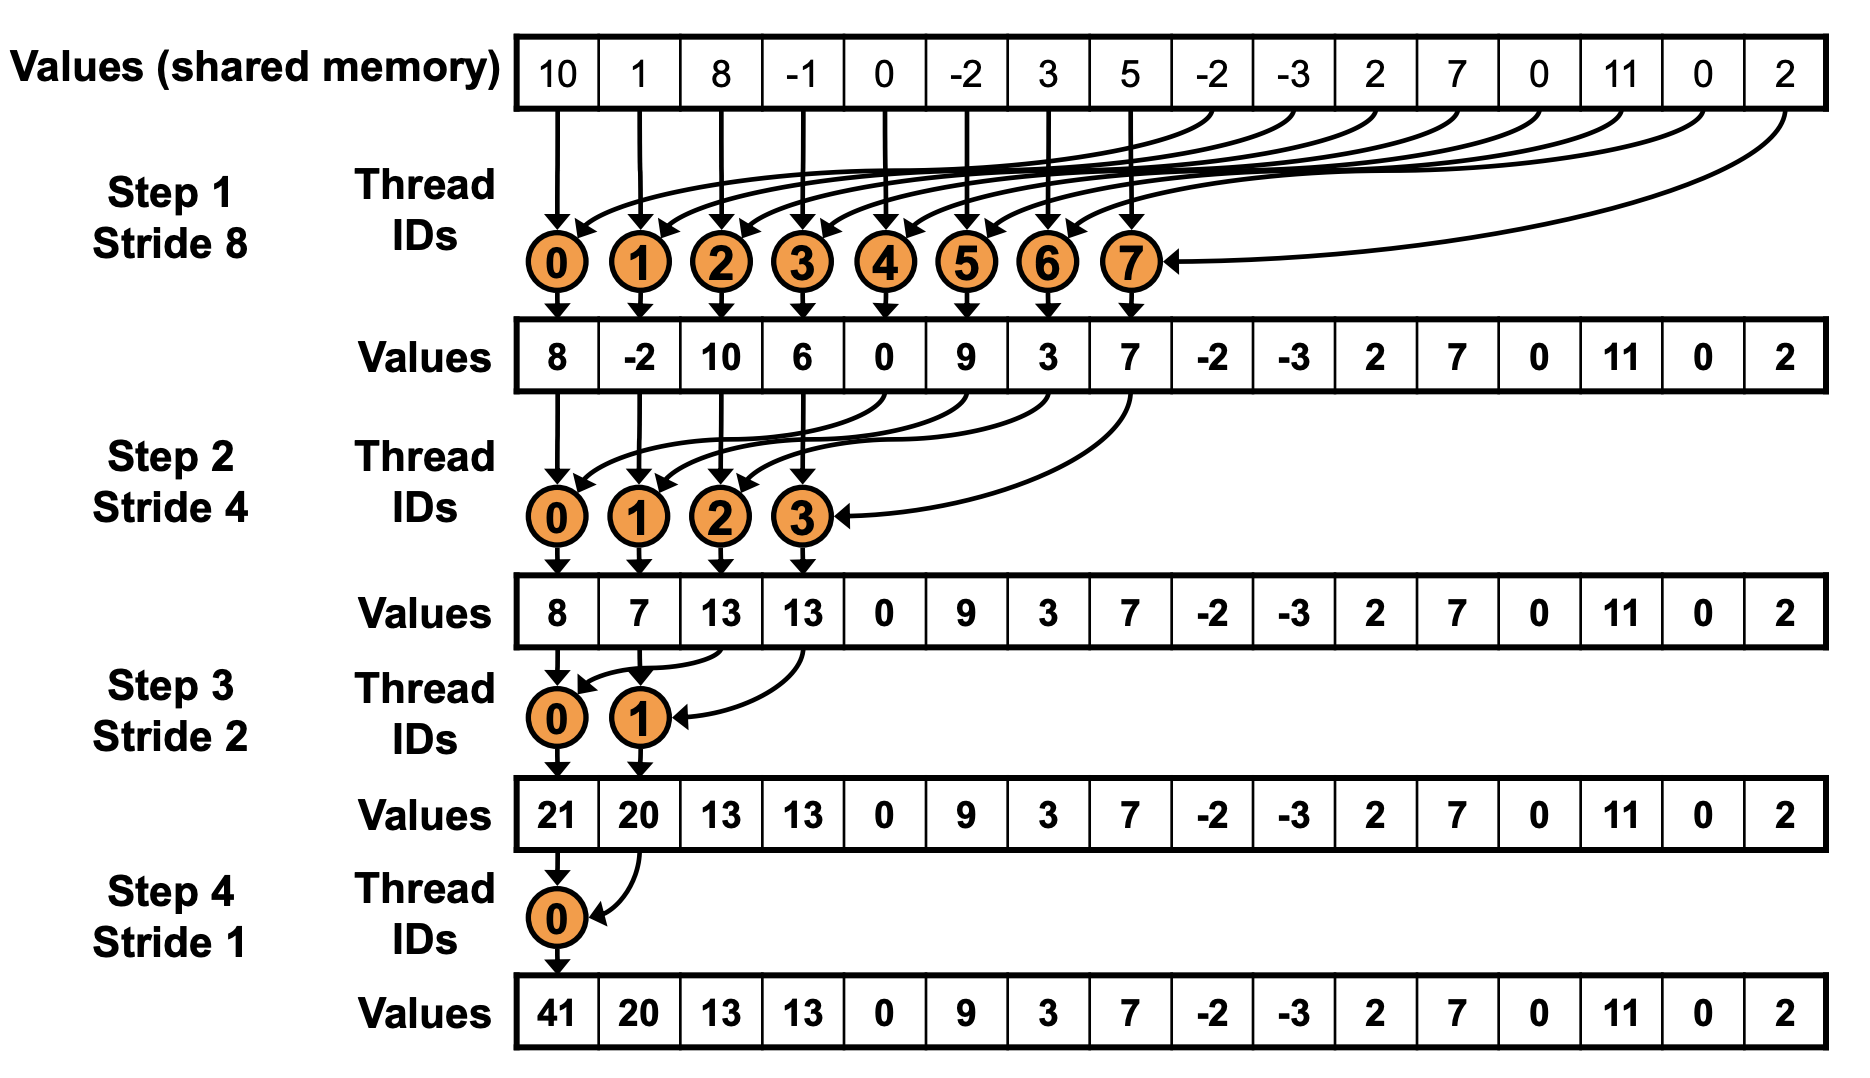

#### What this means for unrolling?

Let's consider an inner loop of a CUDA kernel operating on shared memory that performing a reduction:
  * use half as many threads in each iteration (from a thread block down to 2).
  * merging results to thread 0
  * synchronize across thread blocks on each iteration

```c
for (unsigned int j=blockDim.x >> 1; j>0; j>>=1)
{
  if (tid < j)
    SharedData[tid] += SharedData[tid+j];
  __syncthreads();
}
```

This creates a reduction pattern that is coalesced in memory and minimizes bank conflicts.



And unroll the loop fully

```c
if (tid < 128)
    SharedData[tid] += SharedData[tid+128];
__syncthreads(); 
if (tid < 64)
    SharedData[tid] += SharedData[tid+64];
__syncthreads();

...

if (tid < 1)
    SharedData[tid] += SharedData[tid+1];
__syncthreads();
```

OK, but what do we know about 32 or fewer threads:
  * only thread 0-31 are active
  * the operate in a warp
  * the SIMD property guarantees that they are synchronous
  * remove `__syncthreads()`
  
```c
if (tid < 128)
    SharedData[tid] += SharedData[tid+128];
__syncthreads();
if (tid < 64)
    SharedData[tid] += SharedData[tid+64];
__syncthreads();

if (tid < 32)
{
  SharedData[tid] += SharedData[tid+32];
  SharedData[tid] += SharedData[tid+16];
  SharedData[tid] += SharedData[tid+8];
  SharedData[tid] += SharedData[tid+4];
  SharedData[tid] += SharedData[tid+2];
  SharedData[tid] += SharedData[tid+1];
}
```

* We just eliminated:
    * 5 branching `if` statements
    * 6 barriers (with contention)
    * 1/3 of all instructions in the kernel
* 1/3 seems like way too many, how is that possible?
    * a single instruction gets charged against the whole warp
   